# Gradient descent implementations in SciPy Optimize.

## Needed Libraries import

In [35]:
from helpers import *
import numpy as np
import scipy.optimize as opt

## Gradient Descent implementations with SciPy Optimize

### Minimize function provides interface to optimization algorithms, which are using adaptive learning rate.

In [36]:
def gd_adaptive_lr_opt(func, grad, init):
    x_history = [np.array(init, dtype=float)]

    def callback(xk):
        x_history.append(np.array(xk, dtype=float))

    result = opt.minimize(func, x0=init, jac=grad, method='BFGS', tol=1e-6, callback=callback)

    result.x_history = np.array(x_history)

    return result

### SciPy optimize supplies minimize_scalar function for line search, which can use different algorithms heuristics. We can use it to implement gradient descent with line search.

In [37]:
def gd_line_search_opt(func, grad, init, max_iter=1000, tol=1e-6):
    x = np.array(init, dtype=float)

    x_history = [x.copy()]
    nit = 0
    nfev = 1

    for i in range(max_iter):
        g = grad(x)
        if np.linalg.norm(g) < tol:
            break

        def line_search_func(alpha):
            nonlocal nfev
            nfev += 1
            return func(x - alpha * g)

        res = opt.minimize_scalar(line_search_func, method='golden', tol=1e-6)

        x = x - res.x * g

        x_history.append(x.copy())
        f_val = func(x)
        nit += 1
        nfev += 1

        if np.linalg.norm(x_history[-1] - x_history[-2]) < tol:
            break

    return opt.OptimizeResult(
        x=x,
        fun=func(x),
        jac=grad(x),
        nit=nit,
        nfev=nfev,
        x_history=np.array(x_history),
    )

### Extraction for reuse

In [38]:
# !jupyter nbconvert --to python GD_SciPy.ipynb

## Results

### Symmetrical parabola: $(x - 3)^2 + (y + 2)^2$

Method: gd_adaptive_lr_opt
Initial point: [-5, 3]
Real minimum: (3.0, -2.0)
Method          Found point          f(x)       Iterations      Evals        Error     
------------------------------------------------------------------------------------------
Stat            (3.000, -2.000)       0.000         4             5          0.000000  


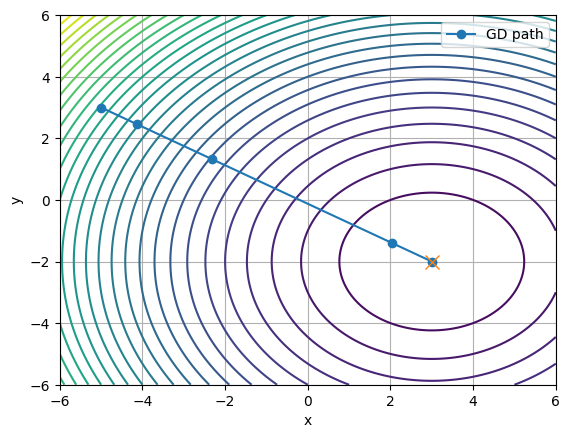

Method: gd_line_search_opt
Initial point: [-5, 3]
Real minimum: (3.0, -2.0)
Method          Found point          f(x)       Iterations      Evals        Error     
------------------------------------------------------------------------------------------
Stat            (3.000, -2.000)       0.000         2             75         0.000000  


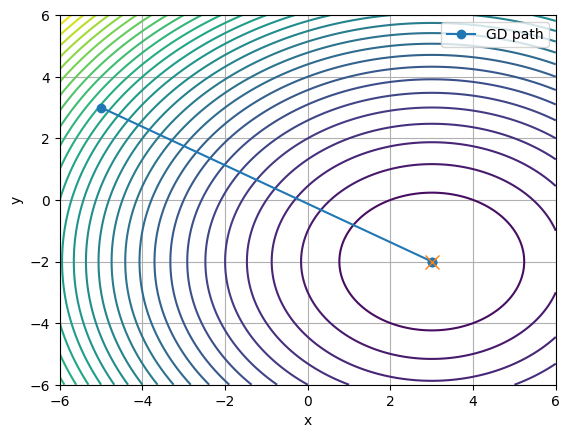

In [39]:
print_output([-5, 3], gd_adaptive_lr_opt, func_sp, grad_sp, [3, -2])
print_output([-5, 3], gd_line_search_opt, func_sp, grad_sp, [3, -2])

### Rotated elliptical function: $2(x + 2)^2 + 4xy + 3(y - 4)^2$

Method: [-30, 30]
Initial point: [-3, -25]
Real minimum: (3.0, -2.0)
Method          Found point          f(x)       Iterations      Evals        Error     
------------------------------------------------------------------------------------------
Stat            (-18.000, 16.000)       -208.000      6             8          0.000000  


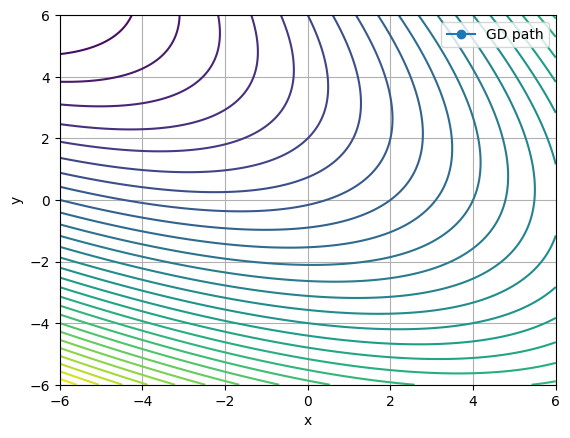

Method: [-30, 30]
Initial point: [-3, -25]
Real minimum: (3.0, -2.0)
Method          Found point          f(x)       Iterations      Evals        Error     
------------------------------------------------------------------------------------------
Stat            (-18.000, 16.000)       -208.000      21            801        0.000000  


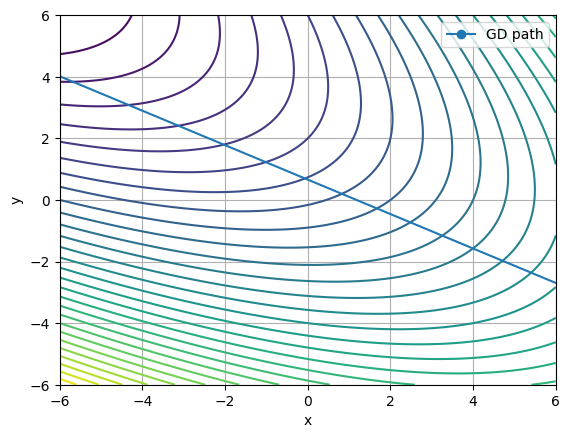

In [40]:
print_output([-3, -25], gd_adaptive_lr_opt, func_re, grad_re, [-18, 16], [-30, 30])
print_output([-3, -25], gd_line_search_opt, func_re, grad_re, [-18, 16], [-30, 30])

### Elliptical function with scale: $8(x - 3)^2 + (y + 1)^2$

Method: gd_adaptive_lr_opt
Initial point: [-5, 3]
Real minimum: (3.0, -2.0)
Method          Found point          f(x)       Iterations      Evals        Error     
------------------------------------------------------------------------------------------
Stat            (3.000, -1.000)       0.000         8             9          0.000000  


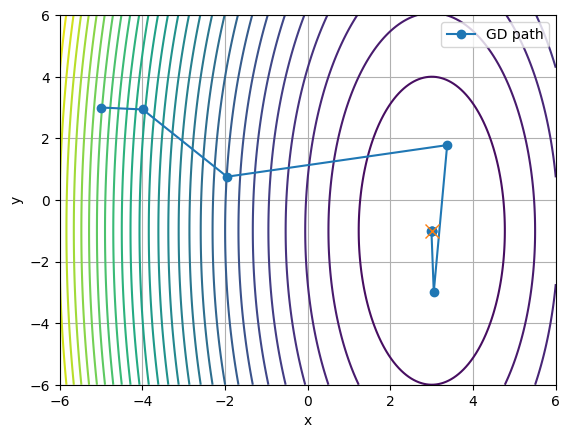

Method: gd_line_search_opt
Initial point: [-5, 3]
Real minimum: (3.0, -2.0)
Method          Found point          f(x)       Iterations      Evals        Error     
------------------------------------------------------------------------------------------
Stat            (3.000, -1.000)       0.000         10            396        0.000000  


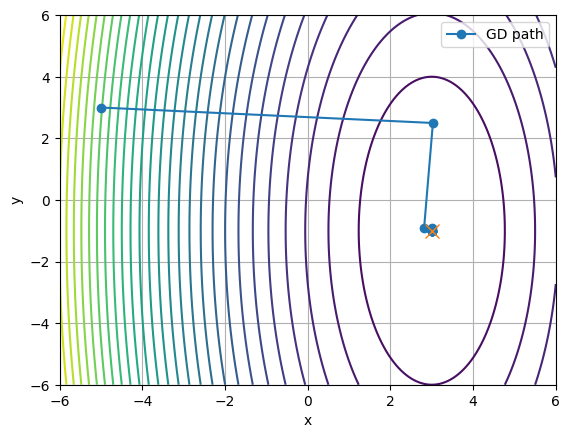

In [41]:
print_output([-5, 3], gd_adaptive_lr_opt, func_es, grad_es, [3, -1])
print_output([-5, 3], gd_line_search_opt, func_es, grad_es, [3, -1])